# Import Package

In [5]:
import os
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from itertools import product
import warnings
warnings.filterwarnings("ignore")
import numpy as np # linear algebra
import pandas as pd


# Data Overview

## Import data

In [6]:
assetinfo = pd.read_csv("asset_details.csv")
ctrain = pd.read_csv("train.csv")

## Asset Information and Dataset Overview

In [7]:
print(assetinfo)

    Asset_ID    Weight        Asset_Name
0          2  2.397895      Bitcoin Cash
1          0  4.304065      Binance Coin
2          1  6.779922           Bitcoin
3          5  1.386294            EOS.IO
4          7  2.079442  Ethereum Classic
5          6  5.894403          Ethereum
6          9  2.397895          Litecoin
7         11  1.609438            Monero
8         13  1.791759              TRON
9         12  2.079442           Stellar
10         3  4.406719           Cardano
11         8  1.098612              IOTA
12        10  1.098612             Maker
13         4  3.555348          Dogecoin


Bitcoin Cash：Bitcoin Cash is the result of a Bitcoin hard fork that happened in August 2017. Bitcoin Cash was created to allow more transactions in a single block,  theoretically decreasing the fees and transaction times. As of March 22, 2022, Bitcoin Cash had a market capitalization of $4.48 billion, ranking it No. 24 among cryptocurrencies by this measure, while Bitcoin was the largest cryptocurrency by far, with its market cap of $808.37 billion more than twice that of second-ranked Ethereum at $360.82 billion.

Binance Coin: Binance Coin is the cryptocurrency issued by the Binance exchange and trades with the BNB symbol. BNB was initially based on the Ethereum network but is now the native currency of Binance's own blockchain, the Binance chain. BNB is a utility cryptocurrency that operates as a payment method for the fees associated with trading on the Binance Exchange. Those who use the token as a means of payment for the exchange can trade at a discount. Now Binance had a market cap of more than $56 billion and ranks behind only Bitcoin, Ethereum, and USD Tether in terms of market cap. 

Bitcoin: (abbreviation: BTC; sign: ₿) A decentralized digital currency that can be transferred on the peer-to-peer bitcoin network.[7] Bitcoin transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain.

EOS.I0:

Ethereum Classic:

Ethereum: (Abbreviation: ETH;[a] sign: Ξ) A decentralized, open-source blockchain with smart contract functionality. Ether is the native cryptocurrency of the platform. Among cryptocurrencies, ether is second only to bitcoin in market capitalization.

Litecoin:

Monero:

TRON:

Stellar:

Cardano: Cardano (ADA) is an “Ouroboros proof-of-stake” cryptocurrency created with a research-based approach by engineers, mathematicians, and cryptography experts. Cardano aims to be the world’s financial operating system by establishing DeFi products similar to Ethereum's and providing solutions for chain interoperability, voter fraud, and legal contract tracing, among other things. 

IOIA:

Maker:

Dogecoin: Dogecoin (DOGE), seen by some as the original “memecoin,” caused a stir in 2021 as its price skyrocketed. The coin, which uses an image of the Shiba Inu as its avatar, is accepted as a form of payment by some major companies.

In [8]:
print(ctrain.head())

    timestamp  Asset_ID  Count        Open        High         Low  \
0  1514764860         2   40.0   2376.5800   2399.5000   2357.1400   
1  1514764860         0    5.0      8.5300      8.5300      8.5300   
2  1514764860         1  229.0  13835.1940  14013.8000  13666.1100   
3  1514764860         5   32.0      7.6596      7.6596      7.6567   
4  1514764860         7    5.0     25.9200     25.9200     25.8740   

        Close       Volume          VWAP    Target  
0   2374.5900    19.233005   2373.116392 -0.004218  
1      8.5300    78.380000      8.530000 -0.014399  
2  13850.1760    31.550062  13827.062093 -0.014643  
3      7.6576  6626.713370      7.657713 -0.013922  
4     25.8770   121.087310     25.891363 -0.008264  


In [9]:
ctrain.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


## Generate Sorting List

In [10]:
asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, row in assetinfo.iterrows()}

asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]

## Timespan Overview

In [11]:
time_list = []
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")  # 以timestamp为index，按照加密货币种类生成df; create dataframe in accordance to the type of crpytocurrency, with timestamp as index 
    beg_time = coin_df.index[0].astype('datetime64[s]') # astype是pandas的数据转换function(如df['clientno'].astype('object'),也可以用to_datetime()), 从数据库中读取的timestamp往往是object格式，将object的日期格式转换成时间格式datetime64(在pandas和numpy下)([s]second,[m]minute,[h]hour,[D]day,[W]week,[M]month,[Y]year,[ms,us,ns,ps,fs,as])
    end_time = coin_df.index[-1].astype('datetime64[s]') #we can use astype to change the type of the data(not limited to time, e.g:df['clientno'].astype('object')), datetime64 is the type of time data under pandas and numpy
    time_list.append([coin, beg_time, end_time])
time_df = pd.DataFrame(time_list)
time_df.columns = ["Asset_Name", "Begin_Time", "End_Time"]
time_df

,Asset_Name,Begin_Time,End_Time
0,Bitcoin,2018-01-01 00:01:00,2021-09-21
1,Ethereum,2018-01-01 00:01:00,2021-09-21
2,Cardano,2018-04-17 09:11:00,2021-09-21
3,Binance Coin,2018-01-01 00:01:00,2021-09-21
4,Dogecoin,2019-04-12 14:34:00,2021-09-21
5,Bitcoin Cash,2018-01-01 00:01:00,2021-09-21
6,Litecoin,2018-01-01 00:01:00,2021-09-21
7,Ethereum Classic,2018-01-01 00:01:00,2021-09-21
8,Stellar,2018-02-16 23:53:00,2021-09-21
9,TRON,2018-02-06 21:37:00,2021-09-21


## Missing data overview

In [12]:
gap_list = []
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    gap_df = (coin_df.index[1:]-coin_df.index[:-1]).value_counts().reset_index() #针对每个币种，计算两个记录之间的时间差(计算结果有60s,120s,180s...),然后计算每种时间差的数量，并以时间差种类为index生成一个序列（索引/时间差/时间差个数）; for each cryptocurrency, calculate the time gap between two records(outcomes include 60s,120s,180s...), then calculate the amount of each type of gap(60s,120s,180s...), finally generate a dataframe with the type of gap as index
    n_gaps = gap_df[gap_df["index"]!=60]["timestamp"].sum() #剔除时间差为60s的数据后，针对每个币种统计不同时间差的个数; from the dataframe previously generated we neglect those 60s
    max_gap = gap_df["index"].max()
    gap_list.append([coin, n_gaps, max_gap])
gap_df = pd.DataFrame(gap_list)
gap_df.columns = ["Asset_Name", "number_of_gaps", "max_gap_in_seconds"]
gap_df

,Asset_Name,number_of_gaps,max_gap_in_seconds
0,Bitcoin,145,2400
1,Ethereum,156,7200
2,Cardano,9360,4800
3,Binance Coin,6600,120720
4,Dogecoin,76652,7260
5,Bitcoin Cash,2502,4380
6,Litecoin,291,5280
7,Ethereum Classic,4707,3780
8,Stellar,37770,8520
9,TRON,12225,3000


In [13]:
missing_list = []
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    missing_list.append([coin, coin_df.shape[0]] + coin_df.isna().sum().tolist()) #coin_df.shape[0]读取某个币种数组的行数(即下面结果中的TotalRows，[1]读取列数, 对于三维张量还有shape[2]; use coin_df_shape[0] we can get the number of rows of the dataframe of each coin (the column "TotalRows" in the outcome, shape[0]-the number of rows, shape[1]-the number of columns, for 3 dimension dataset, there will be shape[2]
missing_df = pd.DataFrame(missing_list)
missing_df.columns = ["Asset_Name", "TotalRows", 'Missing_Asset_ID', 'Missing_Count', 'Missing_Open', 
                      'Missing_High', 'Missing_Low', 'Missing_Close', 'Missing_Volume', 'Missing_VWAP', 'Missing_Target']
missing_df

,Asset_Name,TotalRows,Missing_Asset_ID,Missing_Count,Missing_Open,Missing_High,Missing_Low,Missing_Close,Missing_Volume,Missing_VWAP,Missing_Target
0,Bitcoin,1956282,0,0,0,0,0,0,0,0,304
1,Ethereum,1956200,0,0,0,0,0,0,0,0,340
2,Cardano,1791867,0,0,0,0,0,0,0,0,18731
3,Binance Coin,1942619,0,0,0,0,0,0,0,0,13415
4,Dogecoin,1156866,0,0,0,0,0,0,0,0,144974
5,Bitcoin Cash,1953537,0,0,0,0,0,0,0,0,4861
6,Litecoin,1956030,0,0,0,0,0,0,0,0,521
7,Ethereum Classic,1951127,0,0,0,0,0,0,0,0,9326
8,Stellar,1778749,0,0,0,0,0,0,0,0,61816
9,TRON,1874560,0,0,0,0,0,0,0,0,21014


# Data preprocessing

## Dealing with missing data

### Missing time

In [14]:
allcoin = pd.DataFrame([])
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df_time = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60), method="pad")    # range(star(opt.specifying at which position to start, default is 0), stop(opt.specifying at which position to stop, not included), step(specifying the incrementation, default is 1)) ;  df.fillna(), methods include backfill, bfill, pad, ffill and None, pad is the same as ffill actually https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html
    allcoin = allcoin.append(coin_df_time)

In [15]:
allcoin

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036000,14052.3000,13680.0000,13828.102000,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900000,14000.4000,13601.0000,13801.314000,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512000,13999.0000,13576.2800,13768.040000,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000000,13955.9000,13554.4400,13724.914000,108.501637,13735.586842,-0.008079
...,...,...,...,...,...,...,...,...,...
1632182160,10,32.0,2432.374125,2434.6565,2424.0000,2425.832500,0.908325,2428.051855,NaN
1632182220,10,22.0,2423.134450,2426.0000,2417.0000,2419.437500,1.070306,2420.973654,NaN
1632182280,10,51.0,2417.673900,2423.0000,2414.0000,2421.112000,8.953943,2419.701730,NaN


In [16]:
(allcoin.index[1:]-allcoin.index[:-1]).value_counts().head() #check if there is some surprise that we don't want, those ten hug time gap should be the gap between the end time of one currency and the start time of another one

 60           26080029
-117417540           7
-108226140           1
-77102760            1
-113357220           1
Name: timestamp, dtype: int64

In [17]:
print('Original Dataset Null Summary')
ctrain.isnull().sum()

Original Dataset Null Summary


timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [18]:
print('Modified Dataset Null Summary')  
allcoin.isnull().sum()

# it shows that we add 1,842,694(2593032-750338) rows after dealing with the missing timestamps

Modified Dataset Null Summary


Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP             18
Target      2593032
dtype: int64

### Log Return

Removing Variability Using Logarithmic Transformation
Since the data shows changing variance over time, the first thing we will do to stabilize the variance by applying log transformation using the log() function. The resulting series will be a linear time series.

Removing Linear Trend
Then we perform the first difference transformation z(t) - z(t-1) to our series to remove the linear trend


In [19]:
def log_return(series, periods = 1):
    return np.log(series).diff(periods=periods)

allcoinlret = pd.DataFrame([])
for coin in asset_names:
    coin_df = ctrain[ctrain["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_lret = log_return(coin_df.Close)[1:]
    allcoinlret = allcoinlret.join(coin_lret, rsuffix= coin, how = "outer") # rsuffix - add appendix from the right(Close➡️CloseEthereum) the usage of merge,join, concat and compare https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

In [20]:
allcoinlret

,Close,CloseEthereum,CloseCardano,CloseBinance Coin,CloseDogecoin,CloseBitcoin Cash,CloseLitecoin,CloseEthereum Classic,CloseStellar,CloseTRON,CloseMonero,CloseEOS.IO,CloseIOTA,CloseMaker
timestamp,,,,,,,,,,,,,,
1514764920,-0.001595,-0.000335,NaN,-0.001819,NaN,-0.000970,-0.001555,0.000773,NaN,NaN,-0.000030,-0.000118,NaN,NaN
1514764980,-0.001939,-0.001027,NaN,-0.003494,NaN,-0.000094,0.005072,0.021866,NaN,NaN,-0.000790,-0.000719,NaN,NaN
1514765040,-0.002414,-0.000543,NaN,0.001896,NaN,-0.000631,-0.007662,-0.000756,NaN,NaN,-0.003134,-0.002015,NaN,NaN
1514765100,-0.003137,-0.001898,NaN,-0.005296,NaN,-0.000166,-0.002031,-0.000473,NaN,NaN,-0.002227,-0.003385,NaN,NaN
1514765160,-0.000569,-0.000687,NaN,-0.006645,NaN,-0.001134,-0.003099,-0.001401,NaN,NaN,0.013680,-0.005006,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632182160,-0.002007,-0.003137,-0.007796,-0.003282,-0.003144,-0.002363,-0.002359,-0.001912,-0.003261,-0.002754,-0.002766,-0.003516,-0.004869,-0.003641
1632182220,-0.000910,-0.001305,-0.000610,-0.001980,-0.002531,-0.005945,-0.003906,-0.004158,-0.002748,-0.003939,-0.003065,-0.002115,-0.002737,-0.002640
1632182280,-0.000770,-0.001165,-0.000583,-0.000945,-0.000596,0.000158,-0.001038,-0.001059,-0.002100,-0.000041,-0.000551,-0.000822,-0.001528,0.000692


# Data Visualisation

## Subgroup and Define Function for Data Visualisation and Comparison 

In [185]:
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))


#Subgroup Bitcoin
btc = allcoin[allcoin["Asset_ID"]==1].loc[totimestamp("01/01/2021"):totimestamp("21/09/2021")]

#Subgroup Ethereum
eth = allcoin[allcoin["Asset_ID"]==6].loc[totimestamp("01/01/2021"):totimestamp("21/09/2021")]

#Subgroup Dogecoin
doge = allcoin[allcoin["Asset_ID"]==4].loc[totimestamp("01/01/2021"):totimestamp("21/09/2021")]


In [173]:
#Define a function to plot the closing price and return for btc, eth and doge

def gplot(no, data, porret, label, ylabel, color):
    fig = plt.figure(figsize = (6,9))
    ax = fig.add_subplot(no)
    plt.plot(data[porret], label = label, color = color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


In [176]:
#Defind a function to draw candlestick charts

def cschart(data, label):
    data_recent = data.iloc[-90:]
    csc_fig = plt.figure(figsize = (6,9))
    csc_fig = go.Figure([go.Candlestick(x = data_recent.index, open = data_recent['Open'], high = data_recent['High'], low = data_recent['Low'], close = data_recent['Close'])])
    csc_fig.update_layout(title = {'text':'{:} Candlestick Chart'.format(label), "y":0.9, "x":0.5, 'xanchor':'center', 'yanchor':'top'})
    csc_fig.update_xaxes(title_text = 'Time')
    csc_fig.update_yaxes(title_text = 'Price in USD', ticksuffix = '$')
    csc_fig.plt.tight_layout()
    csc_fig.show()

## Closing Price Trend (Period: year 2021)

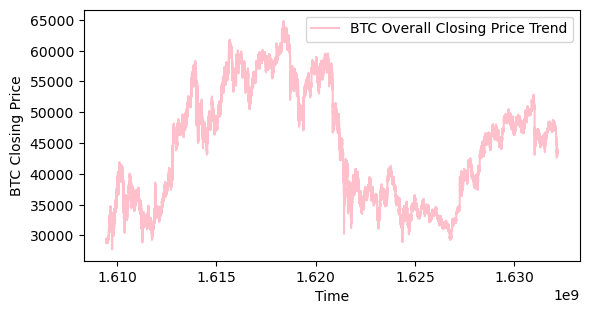

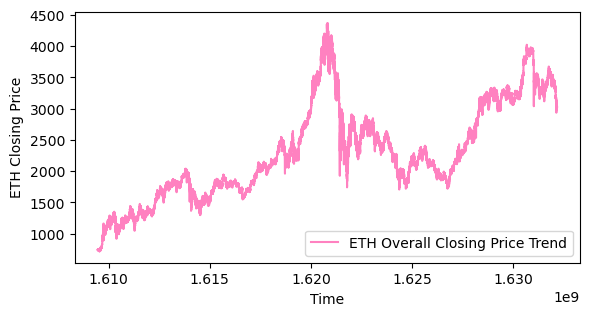

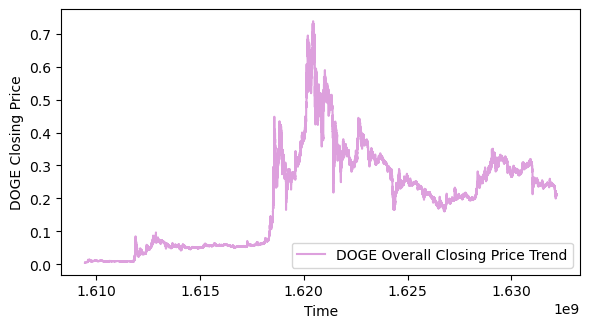

In [174]:
#BTC Price Trend
gplot(no = 311, data = btc,  porret = "Close", label = "BTC Overall Closing Price Trend", ylabel = "BTC Closing Price", color = "#FFC0CB" )

#ETH Price Trend
gplot(no = 312, data = eth, porret = "Close", label = "ETH Overall Closing Price Trend", ylabel = "ETH Closing Price", color = "#ff81c0" )

#DOGE Price Trend
gplot(no = 313, data = doge, porret = "Close", label = "DOGE Overall Closing Price Trend", ylabel = "DOGE Closing Price", color = "#dda0dd" )


The trend charts show that Bitcoin and Ethereum have similar price trend, while Dogecoin, which is xxxxxxx

## Return Trend

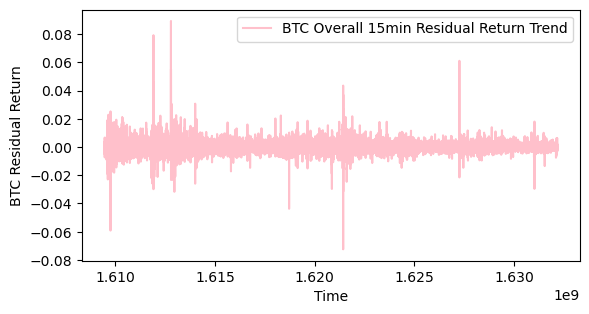

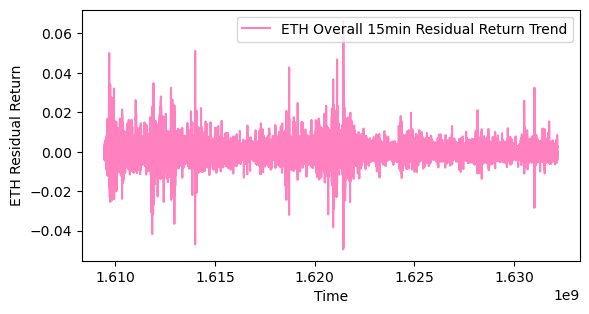

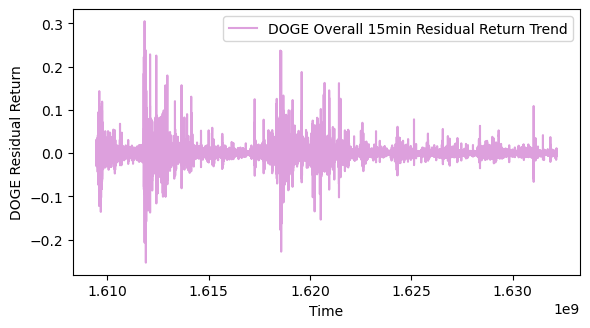

In [177]:
#BTC Return Trend
gplot(no = 311, data = btc, porret = "Target", label = "BTC Overall 15min Residual Return Trend", ylabel = "BTC Residual Return", color = "#FFC0CB" )

#ETH Return Trend
gplot(no = 312, data = eth, porret = "Target", label = "ETH Overall 15min Residual Return Trend", ylabel = "ETH Residual Return", color = "#ff81c0" )

#DOGE Return Trend
gplot(no = 313, data = doge, porret = "Target", label = "DOGE Overall 15min Residual Return Trend", ylabel = "DOGE Residual Return", color = "#dda0dd" )

## Candlestick Chart （Period: 21/09/2021)

In [87]:
cschart(btc, label = "BTC")

cschart(eth, label = "ETH")

cschart(doge, label = "DOGE")

In [186]:
#timestyle = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp))